**Import Necessary Packages**

In [ ]:
!pip install datasets
!pip install rouge
!pip install rouge-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.1/519.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=cad6f3e52706a579ccd5d08b16fc194c91e30ddb805f8cb1a0147739a365bf1b
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


**Import Libraries**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import re
import nltk
import numpy as np
import pandas as pd
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab
from datasets import load_dataset
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.model_selection import train_test_split
from torchtext.data.utils import get_tokenizer, build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt
import seaborn as sns

# **Dataset-Reddit_tifu, long**

In [ ]:
df = load_dataset("reddit_tifu", "long")

features = df["train"].features

for x, y in features.items():
    print(f"{x}: {y.dtype}")

Generating train split:   0%|          | 0/42139 [00:00<?, ? examples/s]

ups: float32
num_comments: float32
upvote_ratio: float32
score: float32
documents: string
tldr: string
title: string


In [ ]:
df = df.map(lambda element: {'summary': element['tldr'], 'text': element['documents']})
df = df.remove_columns(["ups", "upvote_ratio", "num_comments", "score", "title", "tldr", "documents"])

Map:   0%|          | 0/42139 [00:00<?, ? examples/s]

**Download Stop Words**

In [ ]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Below code is to clean text data
def clean_text(text):
    sen = text.lower()
    sen = re.sub(r'http\S+|www\S+|https\S+', '', sen)
    sen = re.sub(r'\([^)]*\)', '', sen)
    sen = re.sub('"','', sen)
    sen = re.sub("[^a-zA-Z]", " ", sen)

    words = []
    for w in sen.split():
      if not w in stop_words:
        words.append(lemmatizer.lemmatize(w))

    return (" ".join(words)).strip()

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Below code is to set the maximum length for text and summary
max_text_length = 450
max_summary_length = 23

# Below code is to initialize lists for text and summary
short_text = []
short_summary = []

# Below code is to iterate through the first 10000 rows of the 'train' DataFrame
for text, summary in zip(df['train']['text'][:10000], df['train']['summary'][:10000]):
    # Clean the text and summary
    neat_text = clean_text(text)
    neat_summary = clean_text(summary)

# Below code is to check if the lengths of cleaned text and summary are really within the limits
    if len(neat_summary.split()) <= max_summary_length and len(neat_text.split()) <= max_text_length:
# Below code is to check that, If within limits then add to the respective lists
        short_text.append(neat_text)
        short_summary.append(neat_summary)

# Below code is to create a new DataFrame with filtered text and summary
dataframe = pd.DataFrame({'text': short_text, 'summary': short_summary})


In [ ]:
dataframe['summary'] = dataframe['summary'].apply(lambda element : 'sostok '+ element + ' eostok')

In [ ]:
x_tr, x_val, y_tr, y_val = train_test_split(np.array(dataframe['text']),np.array(dataframe['summary']),test_size=0.1,random_state=0,shuffle=True)

In [ ]:
# Below code is to create a basic_english tokenizer
tokenizer = get_tokenizer('basic_english')

# Below code is to tokenize the training data
x_tr_tokens = [tokenizer(text) for text in x_tr]  # Here we tokenize input texts
x_val_tokens = [tokenizer(text) for text in x_val]  # Here we tokenize validation input texts
y_tr_tokens = [tokenizer(summary) for summary in y_tr]  # Here we tokenize target summaries
y_val_tokens = [tokenizer(summary) for summary in y_val]  # Here we tokenize validation target summaries

# Below code is to define a function to yield_tokens from an iterator
def yield_tokens(data_iter):
    for text in data_iter:
        yield text

# Below code is to build vocabulary for input texts from the training data
vocab_xtr = build_vocab_from_iterator(yield_tokens(x_tr_tokens))

# Below code is to build vocabulary for target summaries from the training data
vocab_ytr = build_vocab_from_iterator(yield_tokens(y_tr_tokens), min_freq=1, specials=['<pad>', '<unk>', '<sos>', '<eos>'])

# Below code is to build vocabulary for input texts from the validation data
vocab_xval = build_vocab_from_iterator(yield_tokens(x_val_tokens))

# Below code is to build vocabulary for target summaries from the validation data
vocab_yval = build_vocab_from_iterator(yield_tokens(y_val_tokens), min_freq=1, specials=['<pad>', '<unk>', '<sos>', '<eos>'])

In [ ]:
# Below code is to convert all tokenized training input texts to indices
x_tr_indices = [torch.tensor([vocab_xtr[token] for token in tokens]) for tokens in x_tr_tokens]

# Below code is to convert all tokenized validation input texts to indices
x_val_indices = [torch.tensor([vocab_xval[token] for token in tokens]) for tokens in x_val_tokens]

# Below code is to convert all tokenized training target summaries to indices
y_tr_indices = [torch.tensor([vocab_ytr[token] for token in tokens]) for tokens in y_tr_tokens]

y_val_indices = [torch.tensor([vocab_yval[token] for token in tokens]) for tokens in y_val_tokens]

# Below code is to pad sequences of input text indices to have equal lengths
x_tr_indices_padded = pad_sequence(x_tr_indices, batch_first=True, padding_value=0)

# Below code is to pad sequences of training target summary indices to have equal lengths
y_tr_indices_padded = pad_sequence(y_tr_indices, batch_first=True, padding_value=0)

# Below code is to pad sequences of validation input text indices to have equal lengths
x_val_indices_padded = pad_sequence(x_val_indices, batch_first=True, padding_value=0)

# Below code is to pad sequences of validation target summary indices to have equal lengths
y_val_indices_padded = pad_sequence(y_val_indices, batch_first=True, padding_value=0)

# Below code is to create training dataset and loaders
train_dataset = TensorDataset(x_tr_indices_padded, y_tr_indices_padded)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Below code is to create validation dataset and loaders
val_dataset = TensorDataset(x_val_indices_padded, y_val_indices_padded)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


**LSTMSeq2Seq2 model**

In [ ]:
class LSTMSeq2Seq2(nn.Module):
# Below function is for initializing the LSTMSeq2Seq2 model
    def __init__(self, input_dim, output_dim, embedding_dim, hidden_dim, max_text_len):
        super(LSTMSeq2Seq2, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        # Below code is for 3 encoder LSTMs
        self.encoder_lstm1 = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, dropout=0.4, batch_first=True)
        self.encoder_lstm2 = nn.LSTM(hidden_dim, hidden_dim, num_layers=1, dropout=0.4, batch_first=True)
        self.encoder_lstm3 = nn.LSTM(hidden_dim, hidden_dim, num_layers=1, dropout=0.4, batch_first=True)
        # Below code is for 1 decoder LSTM
        self.decoder_lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, dropout=0.4, batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_dim)
# Below function is for Forward pass
    def forward(self, src, trg):
        embedded_src = self.embedding(src)
        embedded_trg = self.embedding(trg)

        # Below code is for 3 encoder LSTMs
        encoder_output1, (state_h1, state_c1) = self.encoder_lstm1(embedded_src)
        encoder_output2, (state_h2, state_c2) = self.encoder_lstm2(encoder_output1)
        encoder_output3, (state_h, state_c) = self.encoder_lstm3(encoder_output2)

        decoder_output, (decoder_fwd_state, decoder_back_state) = self.decoder_lstm(embedded_trg, (state_h, state_c))

        # Attention mechanism
        attn_scores = torch.bmm(decoder_output, encoder_output3.transpose(1, 2))
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_output = torch.bmm(attn_weights, encoder_output3)

        # Fully connected layer(Dense)
        output = self.fc(attn_output)

        return output
# Below code is to set the model hyperparameters
input_dim = len(vocab_xtr)
output_dim = len(vocab_ytr)
embedding_dim = 100
hidden_dim = 300
max_text_len = max(len(tokens) for tokens in x_tr_tokens)

# Below code is to instantiate the LSTMSeq2Seq2 model
model = LSTMSeq2Seq2(input_dim, output_dim, embedding_dim, hidden_dim, max_text_len)
# Display model
print(model)

LSTMSeq2Seq2(
  (embedding): Embedding(32736, 100)
  (encoder_lstm1): LSTM(100, 300, batch_first=True, dropout=0.4)
  (encoder_lstm2): LSTM(300, 300, batch_first=True, dropout=0.4)
  (encoder_lstm3): LSTM(300, 300, batch_first=True, dropout=0.4)
  (decoder_lstm): LSTM(100, 300, batch_first=True, dropout=0.4)
  (fc): Linear(in_features=300, out_features=10546, bias=True)
)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


**Adam Optimizer And Cross Entropy Criterion**

In [ ]:
# Below code is for Setting up the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# CrossEntropyLoss criterion and ignore padding tokens in the loss calculation
criterion = nn.CrossEntropyLoss(ignore_index=vocab_ytr['<pad>'])

In [ ]:
# Below code is to iterate over 20 epochs
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

# Below code is to iterate over batches in the training DataLoader
    for src, trg in tqdm(train_loader):

        optimizer.zero_grad()

# Below code is for Forward pass
        output = model(src, trg[:, :-1])

# Below code is to reshape the output and target tensors for loss calculation
        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:, 1:].contiguous().view(-1)  # Exclude the first token from target

# Below code is to calculate the CrossEntropyLoss between predicted and target tokens of our model
        loss = criterion(output, trg)

# Below code is to backpropagate the gradients and update the model parameters
        loss.backward()
        optimizer.step()

# Below code is to accumulate the loss for the epoch
        total_loss += loss.item()

# Below code is to calculate and print the average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch: {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}')

100%|██████████| 267/267 [02:48<00:00,  1.58it/s]


Epoch: 1/20, Loss: 7.6280


100%|██████████| 267/267 [02:47<00:00,  1.59it/s]


Epoch: 2/20, Loss: 7.3203


100%|██████████| 267/267 [02:47<00:00,  1.59it/s]


Epoch: 3/20, Loss: 7.2453


100%|██████████| 267/267 [02:47<00:00,  1.59it/s]


Epoch: 4/20, Loss: 7.2070


100%|██████████| 267/267 [02:48<00:00,  1.59it/s]


Epoch: 5/20, Loss: 7.1515


100%|██████████| 267/267 [02:48<00:00,  1.59it/s]


Epoch: 6/20, Loss: 7.0975


100%|██████████| 267/267 [02:47<00:00,  1.59it/s]


Epoch: 7/20, Loss: 7.0406


100%|██████████| 267/267 [02:47<00:00,  1.60it/s]


Epoch: 8/20, Loss: 6.9723


100%|██████████| 267/267 [02:48<00:00,  1.58it/s]


Epoch: 9/20, Loss: 6.8908


100%|██████████| 267/267 [02:49<00:00,  1.57it/s]


Epoch: 10/20, Loss: 6.7809


100%|██████████| 267/267 [03:38<00:00,  1.22it/s]


Epoch: 11/20, Loss: 6.6683


100%|██████████| 267/267 [04:25<00:00,  1.01it/s]


Epoch: 12/20, Loss: 6.5353


100%|██████████| 267/267 [04:23<00:00,  1.01it/s]


Epoch: 13/20, Loss: 6.3879


100%|██████████| 267/267 [04:25<00:00,  1.01it/s]


Epoch: 14/20, Loss: 6.2239


100%|██████████| 267/267 [04:24<00:00,  1.01it/s]


Epoch: 15/20, Loss: 6.0630


100%|██████████| 267/267 [04:22<00:00,  1.02it/s]


Epoch: 16/20, Loss: 5.9068


100%|██████████| 267/267 [04:24<00:00,  1.01it/s]


Epoch: 17/20, Loss: 5.7382


100%|██████████| 267/267 [04:24<00:00,  1.01it/s]


Epoch: 18/20, Loss: 5.5780


100%|██████████| 267/267 [04:24<00:00,  1.01it/s]


Epoch: 19/20, Loss: 5.4269


100%|██████████| 267/267 [04:22<00:00,  1.02it/s]

Epoch: 20/20, Loss: 5.2729


**Mount in drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.eval()
model_path = '/content/drive//My Drive/Models/LSTM.pth'
torch.save(model.state_dict(), model_path)

In [ ]:
# Below code is for setting model to evaluation mode
model.eval()

decoder_input = torch.tensor([vocab_ytr['<sos>']] * x_val_indices_padded.size(0)).unsqueeze(1)

max_summary_length = 25
# Below code is to generate the summary using the trained model
with torch.no_grad():
    for i in range(max_summary_length):
        output = model(x_val_indices_padded, decoder_input)
        output_dim = output.shape[-1]
        _, next_token = torch.max(output[:, -1, :], dim=1)
        next_token = next_token.unsqueeze(1)
        decoder_input = torch.cat((decoder_input, next_token), dim=1)

In [ ]:
predicted_summaries = []
# Below code is to iterate over each set of summary indices in the decoder input
for summary_indices in decoder_input:
    summary_tokens = [vocab_ytr.get_itos()[idx.item()] for idx in summary_indices]
    p_summary = ' '.join(summary_tokens[1:])
    predicted_summaries.append(p_summary)


Average ROUGE-1 score: 16.40
Average ROUGE-2 score: 2.62
Average ROUGE-L score: 11.61


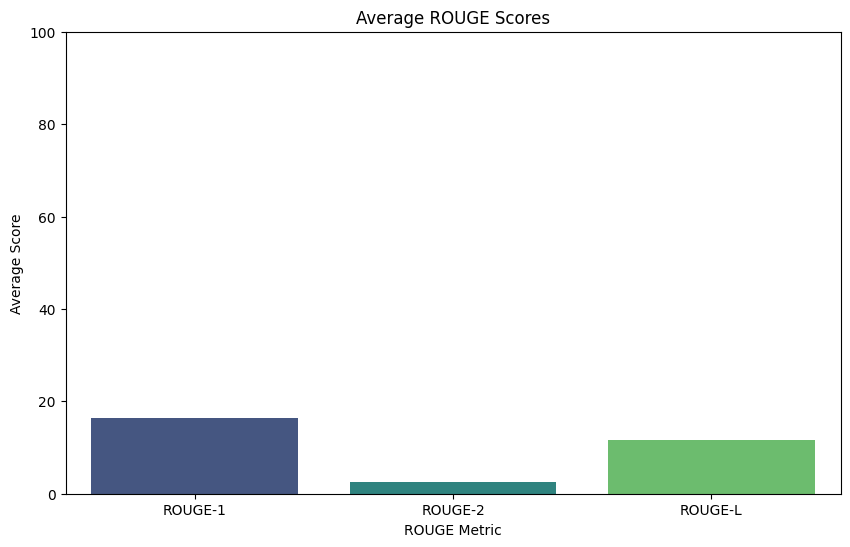

In [ ]:
# Below function is to calculate Rouge scores
def calculate_rouge_scores(pred, ori):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = [scorer.score(pred, ori) for pred, ori in zip(pred, ori)]
    return rouge_scores

original_summaries = dataframe['summary'].tolist()
rouge_scores = calculate_rouge_scores(original_summaries, predicted_summaries)

# Below code is to calculate and print average Rouge scores
average_rouge1 = (sum(scores['rouge1'].fmeasure for scores in rouge_scores) / len(rouge_scores))*100
average_rouge2 = (sum(scores['rouge2'].fmeasure for scores in rouge_scores) / len(rouge_scores))*100
average_rougeL = (sum(scores['rougeL'].fmeasure for scores in rouge_scores) / len(rouge_scores))*100


print(f"Average ROUGE-1 score: {average_rouge1:.2f}")
print(f"Average ROUGE-2 score: {average_rouge2:.2f}")
print(f"Average ROUGE-L score: {average_rougeL:.2f}")



# Below code is to plot for ROUGE scores of LSTM
plt.figure(figsize=(10, 6))
sns.barplot(x=['ROUGE-1', 'ROUGE-2', 'ROUGE-L'], y=[average_rouge1, average_rouge2, average_rougeL], palette='viridis')
plt.title('Average ROUGE Scores')
plt.xlabel('ROUGE Metric')
plt.ylabel('Average Score')
plt.ylim(0, 100)
plt.show()